In [1]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



plt.rcParams["figure.figsize"] = (20, 16)
warnings.simplefilter("ignore")
os.listdir()

['.ipynb_checkpoints',
 'analyse.ipynb',
 'output.csv',
 'whats.csv',
 'youtube20221108_182416.csv',
 'yt.csv',
 'yt_whats.csv']

In [35]:
data = pd.read_csv('youtube20221108_182416.csv')
#data = pd.read_csv('output.csv')

data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id,acquisition
0,2022-11-08 17:25:13.320,62,7424,0.0,6.0,5.0,1,22,-2,904,-2,2,4,youtube20221108_182416
1,2022-11-08 17:25:13.328,62,7432,0.0,6.0,5.0,1,24,-2,19080,-2,36,4,youtube20221108_182416
2,2022-11-08 17:25:13.336,62,7440,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416
3,2022-11-08 17:25:13.346,62,7450,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416
4,2022-11-08 17:25:13.360,62,7464,0.0,6.0,5.0,1,9,-2,936,-2,6,4,youtube20221108_182416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28302,2022-11-08 17:47:34.300,65,6964,0.0,13.0,5.0,1,9,-2,936,-2,6,7,youtube20221108_182416
28303,2022-11-08 17:47:34.312,65,6976,2.0,13.0,5.0,1,28,-2,712,-2,1,7,youtube20221108_182416
28304,2022-11-08 17:47:34.340,65,7004,0.0,13.0,5.0,1,20,-2,840,-2,2,7,youtube20221108_182416
28305,2022-11-08 17:47:34.356,65,7020,0.0,13.0,5.0,1,9,-2,936,-2,6,7,youtube20221108_182416


In [19]:


def first_preprocess(data) :
    data.sort_values(by="Time", ascending=True,inplace =True)
    data.reset_index(drop=True, inplace = True)
    data["Time"] = pd.to_datetime(data.Time, unit='ms')
    reserved_values = [5, 65534, 65535]
    data=data[~data.rnti.isin(reserved_values)] # on enlève les plages reservées
    return data

data = first_preprocess(data)
data

ValueError: non convertible value 2022-11-08 16:16:26.561 with the unit 'ms'

In [36]:
data[["rnti","connection_id"]].value_counts()


rnti  connection_id
65    7                19252
62    4                 5120
63    5                 3495
64    6                  440
dtype: int64

In [37]:
# pour yt et whats connec ID 4 

<AxesSubplot:>

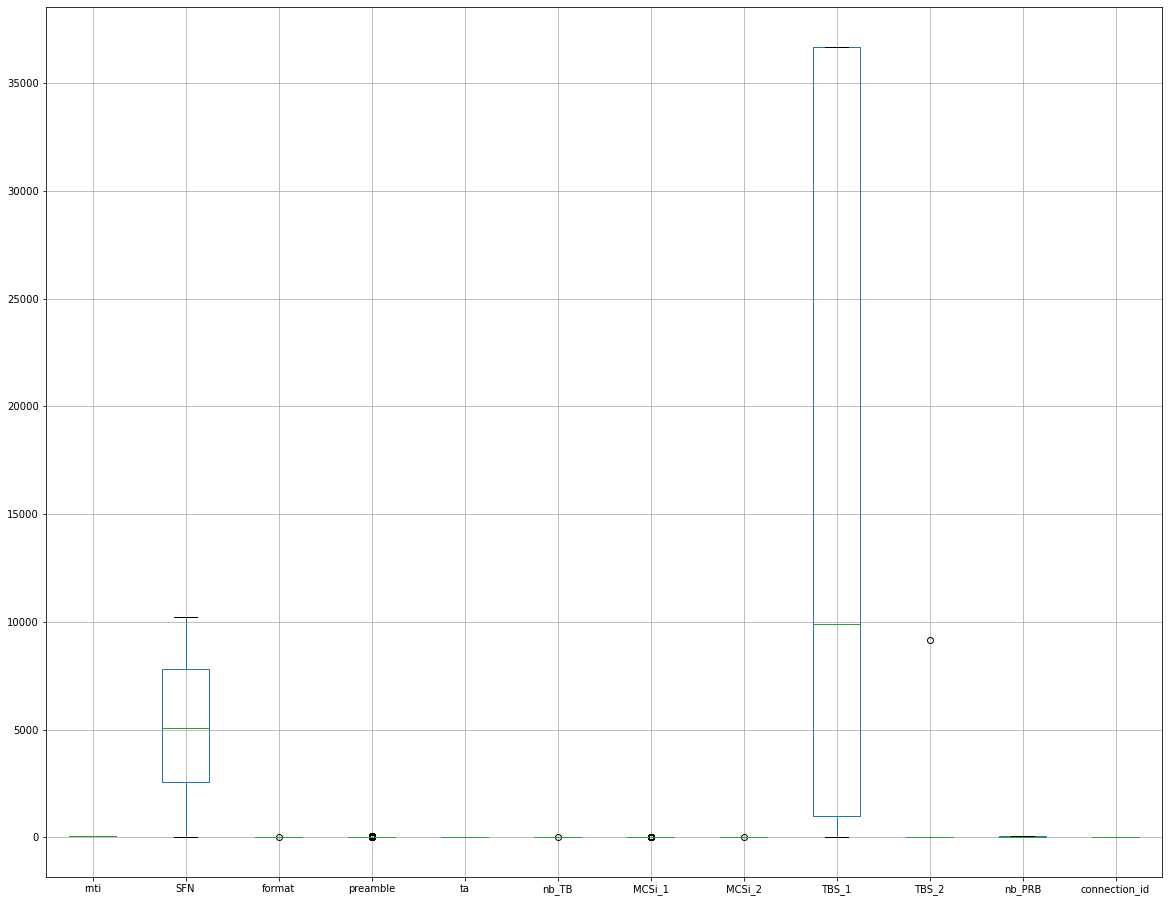

In [38]:
data.boxplot()

In [39]:

def second_preprocess(data) :
    to_concat=[]
    for value in data.connection_id.unique():
        tmp = data[data.connection_id==value]
        tmp["cum_TBS"] = tmp["TBS_1"].cumsum()
        to_concat.append(tmp)
    data = pd.concat(to_concat)
    return data

data = second_preprocess(data)
current_data = data[data.connection_id == 4]
current_data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id,acquisition,cum_TBS
0,2022-11-08 17:25:13.320,62,7424,0.0,6.0,5.0,1,22,-2,904,-2,2,4,youtube20221108_182416,904
1,2022-11-08 17:25:13.328,62,7432,0.0,6.0,5.0,1,24,-2,19080,-2,36,4,youtube20221108_182416,19984
2,2022-11-08 17:25:13.336,62,7440,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416,20696
3,2022-11-08 17:25:13.346,62,7450,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416,21408
4,2022-11-08 17:25:13.360,62,7464,0.0,6.0,5.0,1,9,-2,936,-2,6,4,youtube20221108_182416,22344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,2022-11-08 17:28:12.938,62,2722,2.0,6.0,5.0,1,28,-2,1480,-2,2,4,youtube20221108_182416,72009336
5116,2022-11-08 17:28:12.960,62,2744,0.0,6.0,5.0,1,24,-2,1064,-2,2,4,youtube20221108_182416,72010400
5117,2022-11-08 17:28:12.989,62,2773,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416,72011112
5118,2022-11-08 17:28:13.008,62,2792,2.0,6.0,5.0,1,28,-2,712,-2,1,4,youtube20221108_182416,72011824


In [40]:
def plot_data(data,x="Time", y="cum_TBS"):
    data.plot(x=x, y=y)

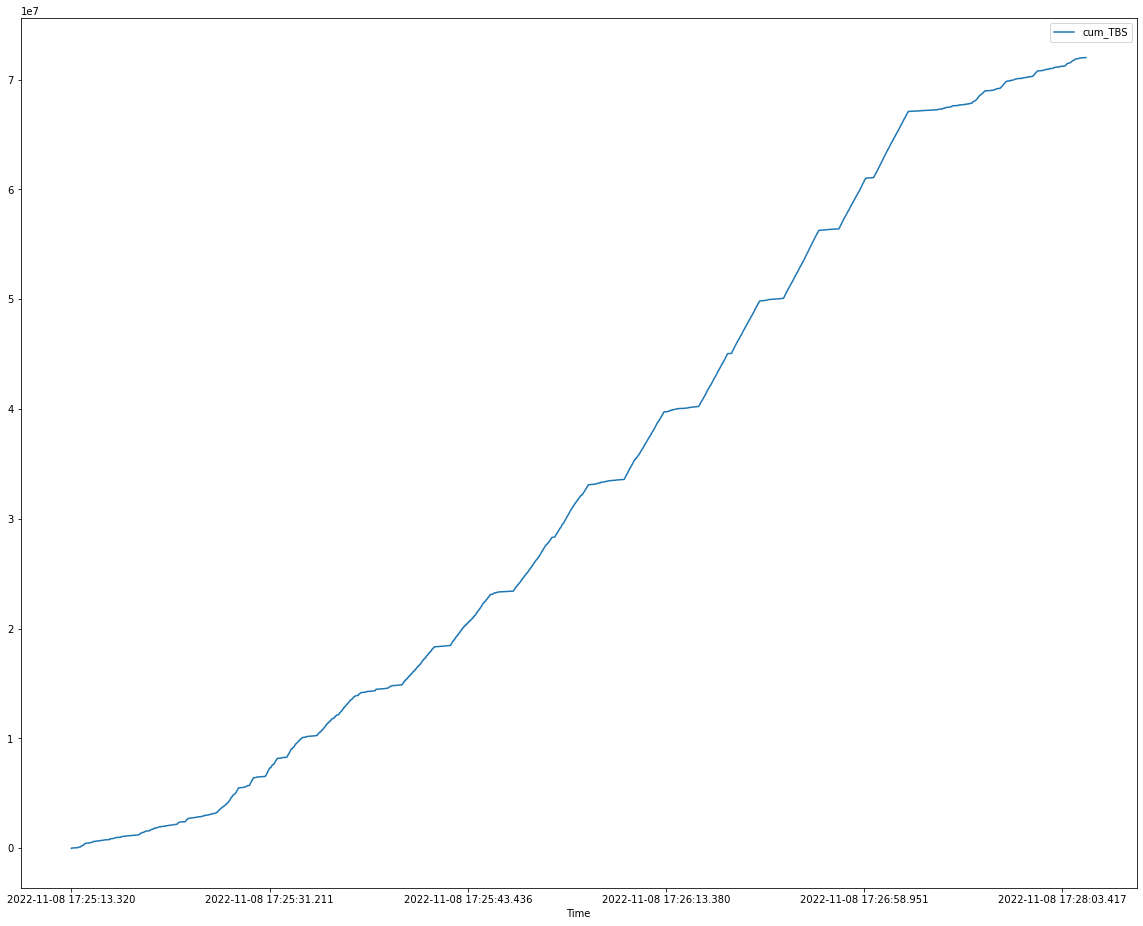

In [41]:
plot_data(current_data)

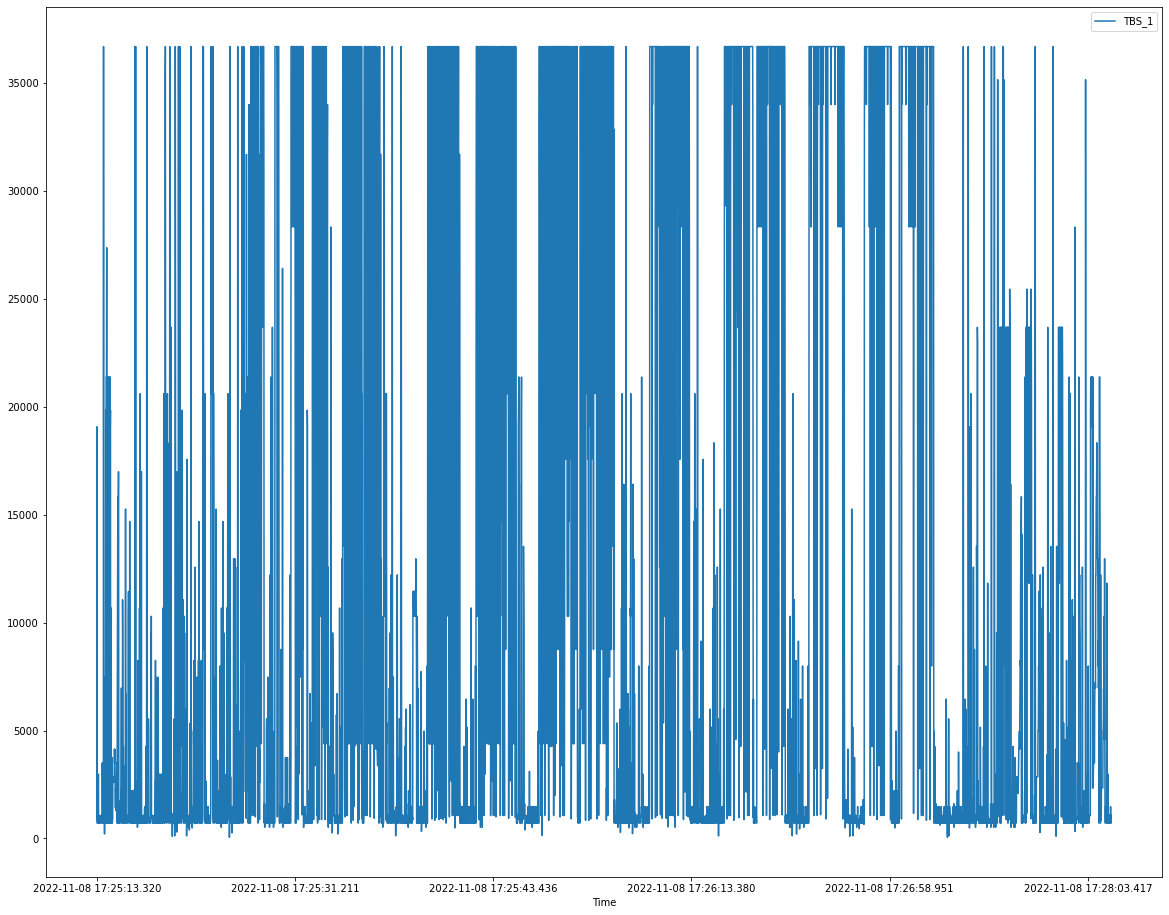

In [42]:
plot_data(current_data,y="TBS_1")

In [43]:
current_data.TBS_1.describe()

count     5120.000000
mean     14065.017187
std      15468.476119
min         56.000000
25%        936.000000
50%       4392.000000
75%      36696.000000
max      36696.000000
Name: TBS_1, dtype: float64

<AxesSubplot:>

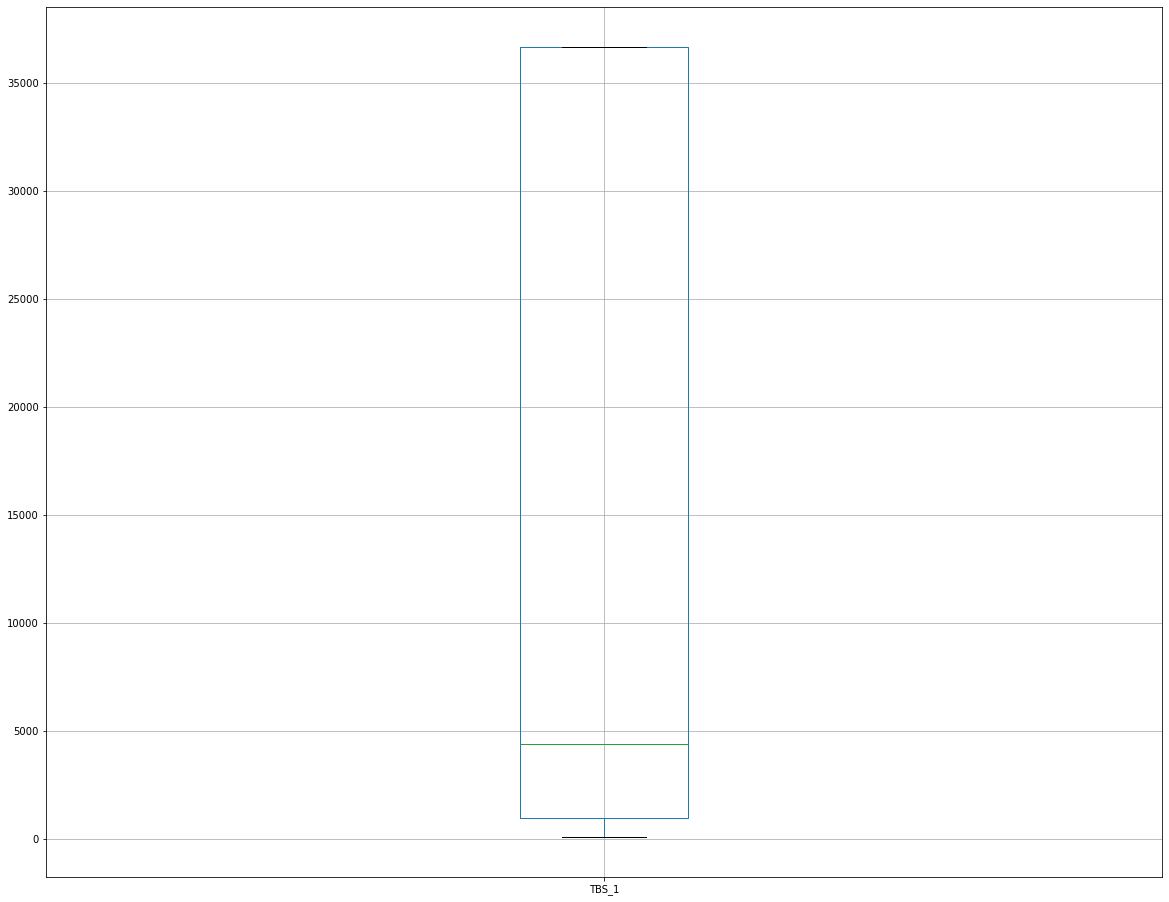

In [44]:
current_data[["TBS_1"]].boxplot()

# Tracé des différents connec_id

In [45]:
to_concat, col_TBS, col_TBS_sum = [], [], []
for value in data.connection_id.unique():
    tmp = data[data.connection_id==value]
    tmp[f"cum_TBS_conn_{value}"] = tmp["TBS_1"].cumsum()
    tmp[f"TBS_1_conn_{value}"] = tmp["TBS_1"]
    col_TBS.append(f"TBS_1_conn_{value}")
    col_TBS_sum.append(f"cum_TBS_conn_{value}")
    to_concat.append(tmp)
extended = pd.concat(to_concat)
extended

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,...,acquisition,cum_TBS,cum_TBS_conn_4,TBS_1_conn_4,cum_TBS_conn_5,TBS_1_conn_5,cum_TBS_conn_6,TBS_1_conn_6,cum_TBS_conn_7,TBS_1_conn_7
0,2022-11-08 17:25:13.320,62,7424,0.0,6.0,5.0,1,22,-2,904,...,youtube20221108_182416,904,904.0,904.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-08 17:25:13.328,62,7432,0.0,6.0,5.0,1,24,-2,19080,...,youtube20221108_182416,19984,19984.0,19080.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-08 17:25:13.336,62,7440,2.0,6.0,5.0,1,28,-2,712,...,youtube20221108_182416,20696,20696.0,712.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-08 17:25:13.346,62,7450,2.0,6.0,5.0,1,28,-2,712,...,youtube20221108_182416,21408,21408.0,712.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-08 17:25:13.360,62,7464,0.0,6.0,5.0,1,9,-2,936,...,youtube20221108_182416,22344,22344.0,936.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28302,2022-11-08 17:47:34.300,65,6964,0.0,13.0,5.0,1,9,-2,936,...,youtube20221108_182416,339370704,NaN,NaN,NaN,NaN,NaN,NaN,339370704.0,936.0
28303,2022-11-08 17:47:34.312,65,6976,2.0,13.0,5.0,1,28,-2,712,...,youtube20221108_182416,339371416,NaN,NaN,NaN,NaN,NaN,NaN,339371416.0,712.0
28304,2022-11-08 17:47:34.340,65,7004,0.0,13.0,5.0,1,20,-2,840,...,youtube20221108_182416,339372256,NaN,NaN,NaN,NaN,NaN,NaN,339372256.0,840.0
28305,2022-11-08 17:47:34.356,65,7020,0.0,13.0,5.0,1,9,-2,936,...,youtube20221108_182416,339373192,NaN,NaN,NaN,NaN,NaN,NaN,339373192.0,936.0


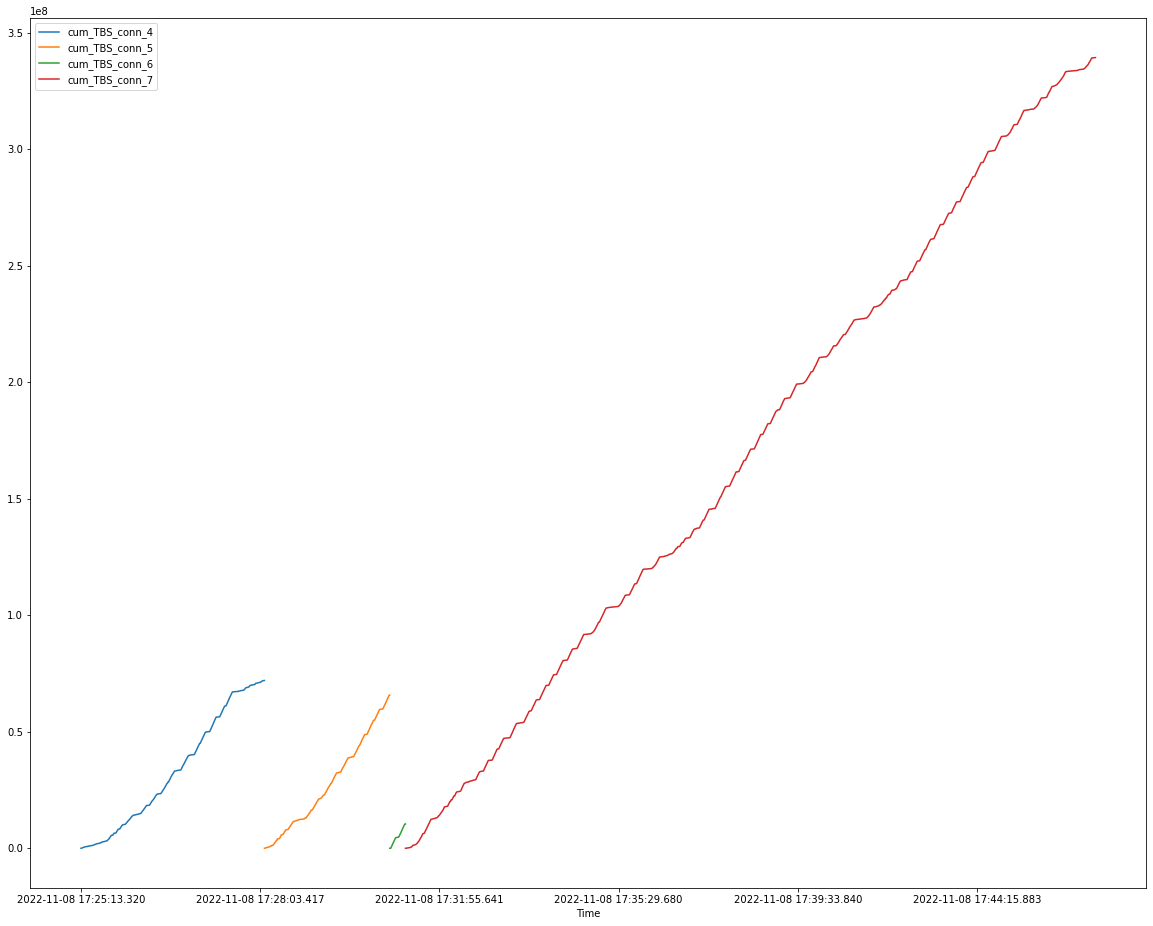

In [46]:
plot_data(extended, y=col_TBS_sum)

# First models

In [14]:
# 'whats.csv', 'yt.csv', 'yt_whats.csv'*


data1 = pd.read_csv('yt_whats.csv')
data2 = pd.read_csv('yt.csv')
data3 = pd.read_csv('whats.csv')


time_series = []
time_series.append((data1[data1.connection_id == 4].TBS_1,"yt"))
time_series.append((data1[data1.connection_id == 5].TBS_1,"noise"))
time_series.append((data1[data1.connection_id == 6].TBS_1,"whats"))

time_series.append((data2[data2.connection_id == 4].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 5].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 6].TBS_1,"yt"))
                   
time_series.append((data3[data3.connection_id == 4].TBS_1,"whats"))
time_series.append((data3[data3.connection_id == 5].TBS_1,"noise"))


time_series = [(ser[0].reset_index(drop=True),ser[1]) for ser in time_series]

time_series = [pd.DataFrame({f"{ser[1]}_{i}" : ser[0]} ) for i, ser in enumerate(time_series)]


#time_series
init_data = pd.concat(time_series, axis = 1)
init_data

,yt_0,noise_1,whats_2,yt_3,yt_4,yt_5,whats_6,noise_7
0,296.0,296.0,296.0,296.0,296.0,296.0,296,296.0
1,408.0,336.0,520.0,336.0,224.0,520.0,520,520.0
2,72.0,72.0,72.0,336.0,224.0,520.0,520,72.0
3,72.0,72.0,72.0,72.0,72.0,72.0,520,72.0
4,32.0,32.0,32.0,72.0,72.0,72.0,520,32.0
...,...,...,...,...,...,...,...,...
20039,NaN,NaN,NaN,NaN,NaN,NaN,840,NaN
20040,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN
20041,NaN,NaN,NaN,NaN,NaN,NaN,1096,NaN
20042,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN


In [20]:
# to apply for each time serie



# format data : 
# 2 colonne = 1time series ( valeurs de TBS + son cumsum ), name col = "{label}_{val or sum}_id"
# les lignes = time codes ( on commence à 0 pour toutes)

def pass_trhough_first_layer(data) :
    list_rows = []
    for i in range(len(data.columns)) : # Pour chaque time serie
        useful_columns = data.columns[i]
        new_row = first_layer(data[useful_columns])
        
        new_row["label"] = useful_columns.split("_")[0]
        list_rows.append(new_row)
    data_final = pd.DataFrame.from_records(list_rows)
        
    
    # concatenate new rows  
    # return concatenation
    
    
    return data_final
    

def first_layer(data):
    metrics = {}
    cum_data = data.cumsum()
    
    
    
    
    # apply scaler
    
    # Here we apply models on cumulated sum
    models = ["reg_lin", "reg_iso", "reg_pol"]
    
    for model in models : 
        
        metrics = apply_simple_model(model, cum_data, metrics)
        
    # Here we can measure other metrics on none cumulated sum
    
    return metrics
    
    
    
    
        
    
def apply_simple_model(model, data, metrics) :
    current_data = data.dropna()
    #print(current_data.index.values.reshape(-1, 1))
    X = current_data.index.values.reshape(-1, 1)
    y = current_data.values
    
    if model =="reg_lin" :
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        metrics["reg_lin_R2"] = reg.score(X, y)
        metrics["reg_lin_coef_A"] = reg.coef_[0]
        
    
    elif model =="reg_iso" :
        
        
        pass
    
    elif model == "reg_pol" :
        
        iso_reg = IsotonicRegression(increasing = True)
        iso_reg.fit(X, y)
        
        metrics["reg_iso_R2"] = iso_reg.score(X, y) # non fonctionnel
        
        if False :
            print("\n")
            print("params iso reg ", iso_reg.get_params(deep=True))
            print(iso_reg.X_thresholds_)
            print(iso_reg.y_thresholds_)
            print(len(iso_reg.X_thresholds_))
            print(len(iso_reg.y_thresholds_)," / ", len(y))
    
    
    return metrics

def scale_data(metrics_data):
    x_train_unscaled = metrics_data[list(metrics_data.columns[:-1])].values
    y_train = metrics_data["label"]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train_unscaled)
    
    new_df = pd.DataFrame(x_train,columns = list(metrics_data.columns[:-1]))
    new_df["label"] = metrics_data['label']
    
    return new_df
    
    
def apply_classifier(metrics_data,model = "KNN", test = True) :
    
    x_train = metrics_data[list(metrics_data.columns[:-1])].values
    y_train = metrics_data["label"]
    
    if test : 
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_test, test_size=0.2,random_state=100)
    
    cv = min(10, int(x_train.shape[0]/3))
    verb = 1
    
    if model == "KNN" :
        
        
        knn = KNeighborsClassifier()
        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)
        
        grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', return_train_score=False,verbose=verb)

        grid_search=grid.fit(x_train, y_train)
        accuracy = grid_search.best_score_ *100
        print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

    
    elif model == "RF":
        
        clf = RandomForestClassifier()
        
        param_grid = {'n_estimators': [15,30, 50, 100],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth' : [2,3,4,5,6,7,8],
                      'criterion' :['gini', 'entropy']
                     }
        
        
        CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring ='accuracy', return_train_score=False,verbose=verb)
        CV_rfc.fit(x_train, y_train)
        
        accuracy = CV_rfc.best_score_ *100
        print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
        
        
    if test :
        pass
        
    
    
    

In [21]:
new_data = pass_trhough_first_layer(init_data)
new_data.drop(columns = ["reg_iso_R2"], inplace = True)
new_data


,reg_lin_R2,reg_lin_coef_A,label
0,0.990482,17906.283145,yt
1,0.904971,2401.120839,noise
2,0.999669,6536.525202,whats
3,0.988323,20197.112974,yt
4,0.998063,29681.483128,yt
5,0.996474,29563.832155,yt
6,0.999779,6416.721630,whats
7,0.986697,1007.776197,noise


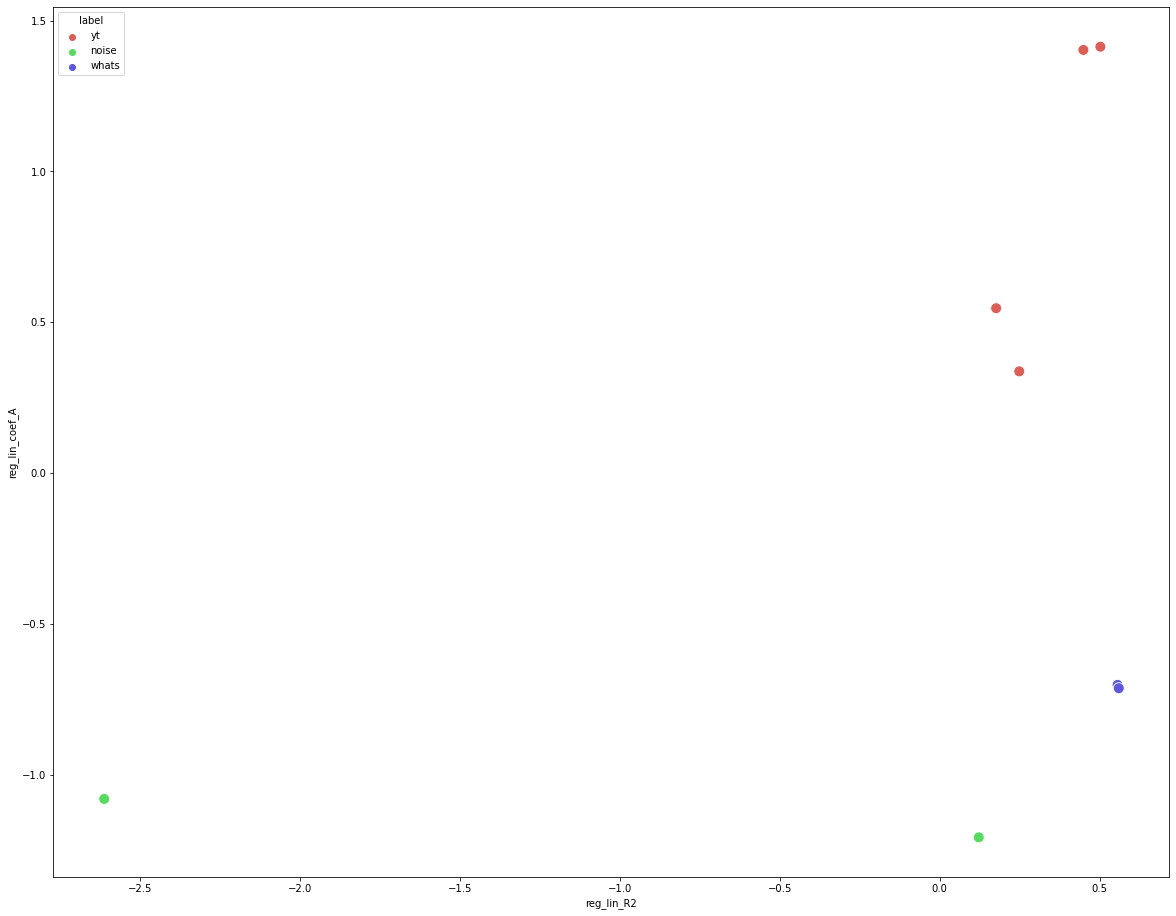

In [26]:
# Scaling
scaled_data = scale_data(new_data)

sns.scatterplot(x='reg_lin_R2' , y='reg_lin_coef_A', data=scaled_data, hue='label',s=120,palette='hls' )
plt.show()


In [23]:
#quite good, le coef de reg lin permet deja de deviner la classe
# whatsapp a aussi les meilleurs R2 de reg lin >0.9995
# La ou yt on est sur : 0.985 -> 0.998
# noise très faible coeff, et R2 faible

In [24]:
apply_classifier(scaled_data ,model = "KNN", test = False)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Accuracy for our training dataset with tuning is : 87.50%


In [25]:
apply_classifier(scaled_data ,model = "RF", test = False)

Fitting 2 folds for each of 168 candidates, totalling 336 fits
Accuracy for our training dataset with tuning is : 100.00%
